# CMB-BEST notebook

This Jupyter notebook demonstrates how to use basic feature of the cmbbest library.

For details about the formailism and its implementation, please refer to the accompanying paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load the cmbbest library
import cmbbest as best

## If you have the hdf5 data file in a non-standard location, provide it below
# best.set_data_path("path_to_your_data_file")

We need two things to get fNL constraints using CMB-BEST: 1) a basis, and 2) a set of models (bispectrum templates).

A basis specifies the type and size of the mode functions used, and also if polarization data is used.

In [2]:
## Prepare the basis for the cmb bispectrum
## The default option is the Legendre basis, p_max=10, temperature + polarization.
basis = best.Basis()

## The following are some alternatives:
# basis_T = best.Basis(polarization_on=False)     # Temperature-only analysis
# basis_hires = best.Basis(mode_p_max=30)         # Higher resolution but slower     
# basis_mono = best.Basis("Monomials")            # KSW estimator (p_max fixed to 4)
# basis_mono_T = best.Basis("Monomials", polarization_on=False)  # KSW estimator, temperature-only
# basis_osc = best.Basis("SineLegendre1000")       # A targeted oscillatory basis with omega=1000 Mpc

A model spcifies the bispectrum shape we would like to constrain.

One can either 1) use a preset template, 2) provide any shape function as a Python function S(k1,k2,k3), or 3) provide numerical evaluations on a regular grid.

In [3]:
## Prepare the bispectrum shapes to constrain
model_list = []

## 1) Some preset shapes
local = best.Model("local")
equil = best.Model("equilateral")
ortho = best.Model("orthogonal")

model_list = model_list + [local, equil, ortho]


## 2) Using custom functions
## Planck analysis often includes this factor in the templates for normalisation:
factor = 6 * (basis.parameter_delta_phi ** 2)        

def constant_shape(k_1, k_2, k_3):
    ## A constant template
    return factor * np.ones_like(k_1)

const = best.Model("custom",
                   shape_function=constant_shape,
                   shape_name="constant")

def feature_models(omega, phi):
    ## Feature model with linear oscillations
    ## Returns a shape function with given frequency and phase
    def shape_function(k_1, k_2, k_3):
        return factor * np.sin(omega * (k_1 + k_2 + k_3) + phi)
    return shape_function

feat_sin = best.Model("custom",
                      shape_function=feature_models(10, 0),
                      shape_name="feature sin")
feat_cos = best.Model("custom", 
                      shape_function=feature_models(10, np.pi/2),
                      shape_name="feature cos")
## Note: for more oscillatory shapes, use the high resolution basis instead

model_list = model_list + [const, feat_sin, feat_cos]


## 3) Using numerical evaluations on a regular grid
k_min, k_max = basis.mode_k_min, basis.mode_k_max   # k ranges needed for the basis
k_grid = np.linspace(k_min, k_max, 50)
k_1, k_2, k_3 = np.meshgrid(k_grid, k_grid, k_grid, indexing="ij")

## Below could be the result of some numerical code instead
shape_evals = factor * np.exp(-0.5 * ((k_1 + k_2 + k_2 - 3 * 0.05) / 0.02) ** 2)

sinlog = best.Model("custom_shape_evals",
                    grid_k_1=k_grid, grid_k_2=k_grid, grid_k_3=k_grid,
                    shape_function_values=shape_evals,
                    shape_name="exponential")

model_list = model_list + [sinlog]

Now we have all the ingredients for the constraints.

Getting constraints is a simple one-liner:

In [4]:
constraints = basis.constrain_models(model_list)
#constraints = basis.constrain_models(model_list, silent=True)  ## Suppress output

Shape #1/7 expanded
Shape #2/7 expanded
Shape #3/7 expanded
Shape #4/7 expanded
Shape #5/7 expanded
Shape #6/7 expanded
Shape #7/7 expanded
Expansion complete.


The result is an instance of cmbbest.Constraints class, which provides some utility functions:

In [5]:
## Get summary or the results
import pandas as pd
with pd.option_context('display.precision', 1):
    display(constraints.summarize())           # Independent shape analysis
    #display(constraints.summarize("joint"))    # Joint analysis

## Get summary table in a latex format
print(constraints.summarize_latex())

## Custom formatting:
#formatter = lambda row: "${:.1f} \pm {:.1f}$".format(row["single_f_NL"], row["single_sample_sigma"])
#print(constraints.summarize_latex(formatter=formatter))

,shape_name,single_f_NL,single_sample_sigma,signal_to_noise
0,local,-1.1,5.3,-2.1e-01
1,equilateral,-21.9,49.0,-4.5e-01
2,orthogonal,-31.9,24.0,-1.3e+00
3,constant,10.8,33.1,3.3e-01
4,feature sin,22.5,42.9,5.2e-01
5,feature cos,51.5,46.1,1.1e+00
6,exponential,7.7,97.0,7.9e-02


\begin{tabular}{lll}
\toprule
      Shape &             Constraint & $f_\mathrm{NL}/\sigma(f_\mathrm{NL})$ \\
\midrule
      local & $-1.1e+00 \pm 5.3e+00$ &                                 -0.21 \\
equilateral & $-2.2e+01 \pm 4.9e+01$ &                                 -0.45 \\
 orthogonal & $-3.2e+01 \pm 2.4e+01$ &                                 -1.33 \\
   constant &  $1.1e+01 \pm 3.3e+01$ &                                  0.33 \\
feature sin &  $2.2e+01 \pm 4.3e+01$ &                                  0.52 \\
feature cos &  $5.1e+01 \pm 4.6e+01$ &                                  1.12 \\
exponential &  $7.7e+00 \pm 9.7e+01$ &                                  0.08 \\
\bottomrule
\end{tabular}



/var/folders/cp/q0v_t5w556s60f4_wf78xysr0000gn/T/ipykernel_22086/394906817.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(constraints.summarize_latex())


In [6]:
## Get the full result
constraints.to_dataframe()

## Save the result to a csv file
## Note that this csv file contains only the constraints.
# constraints.to_csv("results.csv")

,shape_name,convergence_correlation,convergence_epsilon,convergence_MSE,single_f_NL,single_fisher_sigma,single_sample_sigma,single_LISW_bias,marginal_f_NL,marginal_fisher_sigma,marginal_sample_sigma,marginal_LISW_bias
0,local,0.999871,0.016035,2.570924e-04,-1.090607,4.956441,5.308613,5.852253,-4.463543,6.551946,7.016319,7.437229
1,equilateral,1.000000,0.000461,2.129463e-07,-21.855935,45.101738,48.982510,0.538426,-1979.921491,2816.320288,2758.455353,-471.554290
2,orthogonal,0.999992,0.004113,1.691748e-05,-31.906637,21.950178,24.035169,-10.049864,599.164812,932.493856,910.394089,155.704920
3,constant,0.999998,0.001838,3.379628e-06,10.830584,29.627434,33.106102,7.557915,1649.643707,2366.410469,2315.548221,383.986494
4,feature sin,0.999999,0.001624,2.638598e-06,22.452955,38.157326,42.904082,7.791405,21.899598,105.118654,101.199657,-5.534927
5,feature cos,0.999998,0.002054,4.220491e-06,51.496486,48.374739,46.050193,-6.610699,192.716855,169.861057,163.400817,25.067658
6,exponential,0.976205,0.218150,4.702302e-02,7.659111,88.325408,96.986361,4.118418,-148.151771,140.721581,137.441215,-16.407612


When studying both the T and T+E constraints, you can save time by doing the basis expansion and saving the results.

As long as the same basis functions are used, the expansion coefficients are the same and can be passed to get constraints faster.

In [7]:
basis_TE = best.Basis()
basis_T = best.Basis(polarization_on=False)
std_models = [best.Model("local"), best.Model("equil"), best.Model("ortho")]

## Compute the expansion coefficients
coeff, shape_cov, conv_corr, conv_MSE = basis_TE.basis_expansion(std_models, check_convergence=True)
# coeffs = basis_TE.basis_expansion(std_models, check_convergence=False)     # Skip convergence checks

## Constrain models
constraints_TE = basis_TE.constrain_models(std_models, coeff, conv_corr, conv_MSE)
constraints_T = basis_T.constrain_models(std_models, coeff, conv_corr, conv_MSE)
# constraints_TE = basis_TE.constrain_models(std_models, coeff)              # If you skipped checks
# constraints_T = basis_T.constrain_models(std_models, coeff)

Shape #1/3 expanded
Shape #2/3 expanded
Shape #3/3 expanded
Expansion complete.


A simple function using GetDist is provided to plot the (marginal) likelihood for the joint analyses.

Note that the Fisher matrix is used in the plot, which may slighly underestimate the errors. For joint analysis with multiple shapes that are strongly correlated with each other, the plotmaking may fail or give unreliable results. Reduce the number of models under considerations in this case.

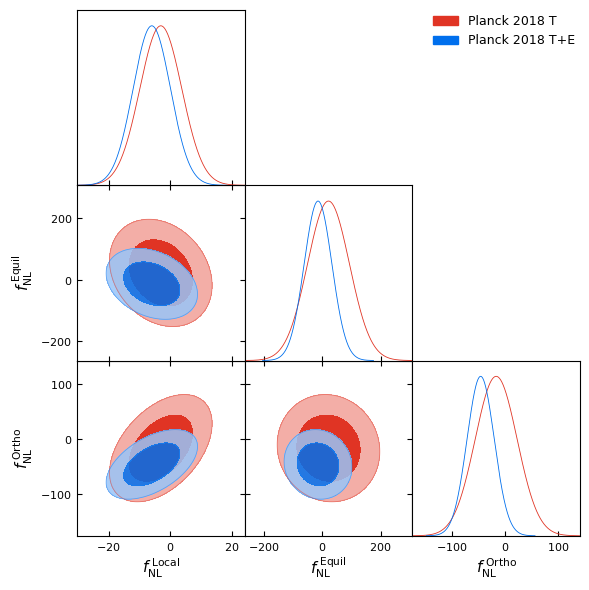

In [8]:
## Triangle plot of the fNL likelihood
best.Constraints.triangle_plot([constraints_T, constraints_TE],
                                constraints_labels=["Planck 2018 T", "Planck 2018 T+E"],
                                shape_labels=[("f_\mathrm{NL}^\mathrm{\;" + s + "}") for s in ["Local", "Equil", "Ortho"]],
                                plot_kwargs={"filled": True})